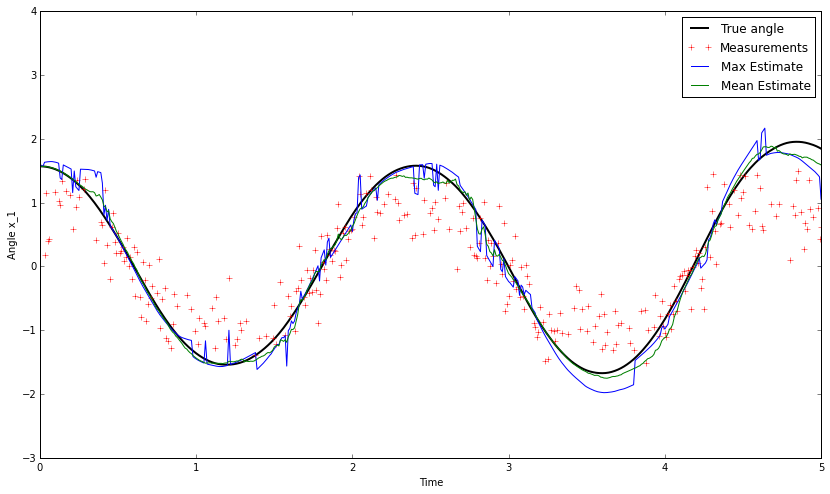

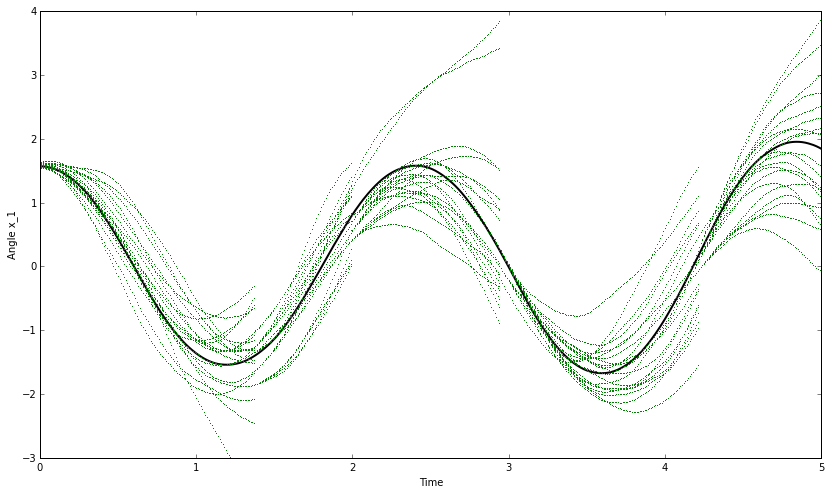

In [1]:
# Most of this code by Romain HERAULT (INSA Rouen)

import numpy as np
import cPickle as pickle
import particlefilter
import matplotlib
import matplotlib.pyplot as plt
import pylab

%matplotlib inline
pylab.rcParams['figure.figsize'] = (14.0, 8.0)

filependulum='pendulum.pick'

def f(x,param):
    ret=np.zeros((2,))
    ret[0]=x[0]+x[1]*param['dt']
    ret[1]=x[1]-param['g']*np.sin(x[0])*param['dt']
    return ret

def h(x,param):
    ret=np.zeros((1,))
    ret[0]=np.sin(x[0])
    return ret

def getQ(param):
    Q=np.zeros((2,2))
    Q[0,0]=(param['q']*(param['dt']**3))/3.
    Q[1,0]=(param['q']*(param['dt']**2))/2.
    Q[0,1]=(param['q']*(param['dt']**2))/2.
    Q[1,1]=param['q']*param['dt']

    return Q

def performsFiltering(filein):

    data=pickle.load(open(filein,'r'))

    time=data['time']
    states=data['states']
    observations=data['observations']
    anglemeasurements=data['anglemeasurements']
    param=data['param']
    param['q']= param['q']*50

    n=observations.shape[0]

    transition_function=lambda x:f(x,param)
    observation_function=lambda x:h(x,param)

    transition_covariance=getQ(param)
    observation_covariance=np.atleast_2d(np.array([param['r']]))

    start_mean=param['x0']
    start_covariance=param['p0'];

    #PF
    nParticles=20;
    np.random.seed(3)
    pf=particlefilter.ParticleFilter(transition_function,transition_covariance,
                 observation_function,observation_covariance,
                 start_mean,start_covariance)

    (particles,weights)=pf.forward(nParticles,observations,nParticles/5.)

    max_estimate=pf.estimateStatesFromMax(particles,weights)
    mean_estimate=pf.estimateStatesFromMean(particles,weights)
    ##END PF

    plt.figure()
    plt.plot(time,states[:,0],'k-',linewidth=2)
    plt.plot(time[1:],anglemeasurements,'r+')
    plt.plot(time,max_estimate[:,0],'b-',linewidth=1)
    plt.plot(time,mean_estimate[:,0],'g-',linewidth=1)
    plt.xlabel('Time')
    plt.ylabel('Angle x_1')
    plt.ylim([-3,4])
    plt.legend(['True angle','Measurements','Max Estimate','Mean Estimate'])

    plt.figure()
    plt.plot(time,states[:,0],'k-',linewidth=2)
    for i in range(len(time)):
        plt.plot([time[i]]*nParticles,particles[i,:,0],'g,')
    plt.xlabel('Time')
    plt.ylabel('Angle x_1')
    plt.ylim([-3,4])

performsFiltering(filependulum)
